# Simulation using Concord

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

In [4]:
proj_name = "simulation_tree_partial"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = f"../data/{proj_name}/"
data_dir = Path(data_dir)
data_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 0
ccd.ul.set_seed(seed)

file_suffix = f"{time.strftime('%b%d-%H%M')}"
file_suffix

cpu


'Jul29-1643'

In [5]:
concord_methods = ['concord_hcl', 'concord_knn', 'contrastive']
other_methods = [
        "unintegrated",
        "scanorama", "liger", "harmony",
        "scvi", 
]
run_methods = concord_methods + other_methods
# exclude ["UMAP", "t-SNE"] from run_method, and save as combined_keys
exclude_keys = ["PCA", "UMAP", "t-SNE"]
combined_keys = ['no_noise', 'wt_noise'] + [key for key in run_methods if key not in exclude_keys]

In [6]:
group_key = 'depth'
batch_key = 'batch'
state_key = 'branch'
leiden_key = 'leiden_no_noise'
state_type = 'tree'
time_key = 'time'
batch_type = 'batch_specific_features'
distribution = 'normal'

In [19]:
# ------------------------------------------------------------------
# 1)  Imports
# ------------------------------------------------------------------
import numpy as np
from concord.simulation import (
    Simulation,           # the refactored Simulation class
    SimConfig,
    TreeConfig,
    BatchConfig,
)

# ------------------------------------------------------------------
# 2)  GLOBAL simulation settings  (was the leading scalar kwargs)
# ------------------------------------------------------------------
sim_cfg = SimConfig(
    n_cells = 1000,
    n_genes = 1000,
    seed    = seed,
    non_neg = True,
    to_int  = True,
)

# ------------------------------------------------------------------
# 3)  STATE configuration  (was *tree_* and other state_* kwargs)
# ------------------------------------------------------------------
tree_cfg = TreeConfig(
    # === type & distribution ===
    distribution              = "normal",     # state_distribution
    level                     = 10,           # state_level
    min_level                 = 1,            # state_min_level
    dispersion                = 3.0,          # state_dispersion

    # === tree topology ===
    branching_factor          = 2,            # tree_branching_factor
    depth                     = 2,            # tree_depth

    # === expression programme inside each branch ===
    program_structure         = "dimension_increase",
    program_on_time_fraction  = 0.10,
    program_gap_size          = 1,
    program_decay             = 0.7,          # tree_program_decay
    cellcount_decay           = 1.0,          # (unchanged default)

    # keep noise within each block ON 
    noise_in_block            = False,
)

# ------------------------------------------------------------------
# 4)  BATCH configuration  (was the batch_* kwargs)
# ------------------------------------------------------------------
batch_cfg = BatchConfig(
    n_batches     = 2,
    effect_type   = "batch_specific_features",   # batch_type
    distribution  = "normal",                    # batch_distribution
    level         = [10, 10],                    # batch_level
    dispersion    = [3.0, 3.0],                  # batch_dispersion
    feature_frac  = 0.10,                        # batch_feature_frac (default 0.1)
    # cell_proportion left at default (equal split)
)

# ------------------------------------------------------------------
# 5)  Run the simulation
# ------------------------------------------------------------------
sim         = Simulation(sim_cfg, tree_cfg, batch_cfg)
adata, pre  = sim.simulate_data()

# keep a copy of counts, exactly as before
adata.layers["counts"] = adata.X.copy()

# Generate the simulated data
adata_state = sim.simulate_state()
print(adata_state.shape)

(1750, 1088)


In [20]:
# Compute time range
time_split_1 = adata_state.obs['time'].max() * 0.5
time_split_2 = adata_state.obs['time'].max() * 0.9
batch1_time = adata_state.obs['time'] < time_split_2
batch2_time = adata_state.obs['time'] > time_split_1
batch1_idx = np.where(batch1_time)[0]
batch2_idx = np.where(batch2_time)[0]

batch_indices = {0: batch1_idx, 1: batch2_idx}


In [21]:
batch_list, state_list = [], []
for i in range(len(batch_indices)):
    batch_adata_pre = adata_state[batch_indices[i]].copy()
    batch_adata = sim.simulate_batch(
        batch_adata_pre,
        batch_idx=i)
    batch_list.append(batch_adata)
    state_list.append(batch_adata_pre)

adata = sim._finalize_anndata(batch_list, join='outer')
adata_state = sim._finalize_anndata(state_list, join='outer')


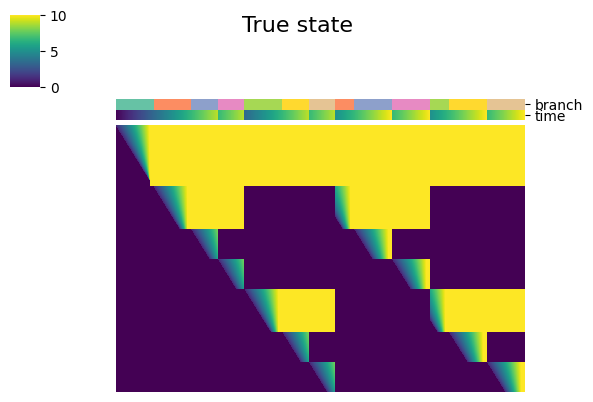

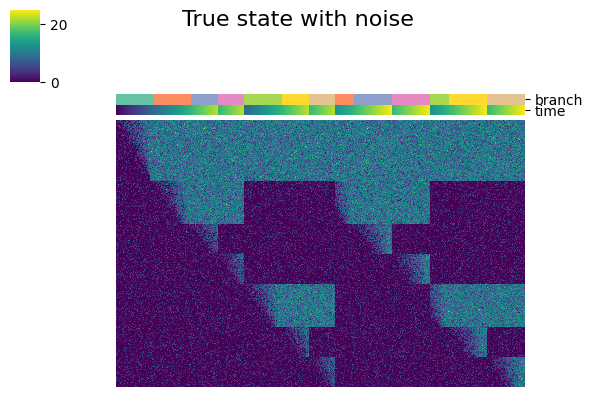

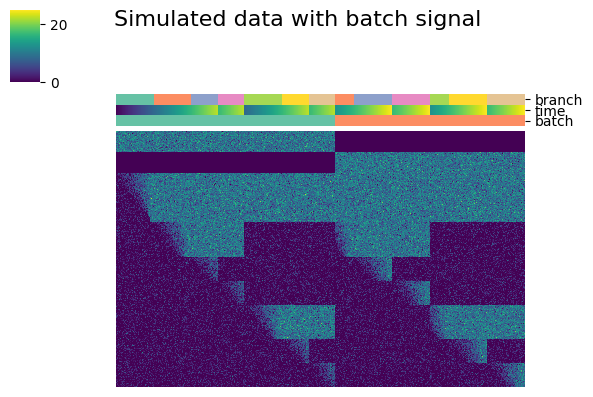

In [22]:
ccd.pl.heatmap_with_annotations(adata_state, val='no_noise', obs_keys=[state_key, time_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state', save_path=save_dir/f'true_state_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata_state, val='wt_noise', obs_keys=[state_key, time_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state with noise', save_path=save_dir/f'true_state_with_noise_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key, time_key, batch_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Simulated data with batch signal', save_path=save_dir/f'simulated_data_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)

### Integration pipeline

In [28]:
run_methods = concord_methods + other_methods
#run_methods = concord_methods
latent_dim = 30


In [29]:
# Add ground truth
ccd.ul.run_pca(adata_state, source_key='no_noise', result_key='no_noise_PCA', n_pc=latent_dim, random_state=seed)
ccd.ul.run_pca(adata_state, source_key='wt_noise', result_key='wt_noise_PCA', n_pc=latent_dim, random_state=seed)
# Put the PCA result in the adata object, so only one object is needed
adata.obsm['no_noise'] = adata.obsm['no_noise_PCA'] = adata_state.obsm['no_noise_PCA']
adata.obsm['wt_noise'] = adata.obsm['wt_noise_PCA'] = adata_state.obsm['wt_noise_PCA']
ccd.ul.run_umap(adata, source_key='no_noise', result_key='no_noise_UMAP', n_components=2, random_state=seed)
ccd.ul.run_umap(adata, source_key='wt_noise', result_key='wt_noise_UMAP', n_components=2, random_state=seed)

In [30]:
concord_kwargs = {
    'batch_size': 32,
    'n_epochs': 20,
    'load_data_into_memory': True,
    'verbose': False,
}
profile_logs = ccd.bm.run_integration_methods_pipeline(
    adata=adata,                          # Your input AnnData object
    methods=run_methods,            # List of methods to run
    batch_key=batch_key,                    # Column in adata.obs for batch info
    count_layer="counts",                 # Layer name containing raw counts
    class_key=state_key,               # Column in adata.obs for class labels (used in SCANVI and CONCORD variants)
    latent_dim=latent_dim,                        # Latent dimensionality for PCA and embeddings
    device="cpu",                        # Or "cpu", or "mps" for Apple Silicon
    return_corrected=False,                   # Whether to store corrected expression matrices
    transform_batch=None,                 # Optionally specify a batch to transform to in scVI
    seed=seed,                              # Random seed for reproducibility
    compute_umap=False,                        # Run UMAP for all output embeddings
    umap_n_components=2,
    umap_n_neighbors=30,
    umap_min_dist=0.5,
    verbose=True,                        # Print progress messages
    concord_kwargs=concord_kwargs,          # Additional kwargs for CONCORD
)


concord - WARNING - save_dir is None. Model and log files will not be saved.
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Epoch 0 Training
Epoch 1 Training
concord - WARNING - FAISS not found. Using sklearn for k-NN computation.
Epoch 2 Training
Epoch 3 Training
Epoch 4 Training
Epoch 5 Training
Epoch 6 Training
Epoch 7 Training
Epoch 8 Training
Epoch 9 Training
Epoch 10 Training
Epoch 11 Training
Epoch 12 Training
Epoch 13 Training
Epoch 14 Training
Epoch 15 Training
Epoch 16 Training
Epoch 17 Training
Epoch 18 Training
Epoch 19 Training
concord - WARNING - save_dir is None. Skipping model/config saving.


concord_knn: 7.56s | 5.02 MB RAM | 0.00 MB VRAM


concord - WARNING - save_dir is None. Model and log files will not be saved.
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Epoch 0 Training
Epoch 1 Training
Epoch 2 Training
Epoch 3 Training
Epoch 4 Training
Epoch 5 Training
Epoch 6 Training
Epoch 7 Training
Epoch 8 Training
Epoch 9 Training
Epoch 10 Training
Epoch 11 Training
Epoch 12 Training
Epoch 13 Training
Epoch 14 Training
Epoch 15 Training
Epoch 16 Training
Epoch 17 Training
Epoch 18 Training
Epoch 19 Training
concord - WARNING - save_dir is None. Skipping model/config saving.


concord_hcl: 5.23s | 0.06 MB RAM | 0.00 MB VRAM


concord - WARNING - save_dir is None. Model and log files will not be saved.
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.
concord - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
Epoch 0 Training
Epoch 1 Training
Epoch 2 Training
Epoch 3 Training
Epoch 4 Training
Epoch 5 Training
Epoch 6 Training
Epoch 7 Training
Epoch 8 Training
Epoch 9 Training
Epoch 10 Training
Epoch 11 Training
Epoch 12 Training
Epoch 13 Training
Epoch 14 Training
Epoch 15 Training
Epoch 16 Training
Epoch 17 Training
Epoch 18 Training
Epoch 19 Training
concord - WARNING - save_dir is None. Skippin

contrastive: 5.09s | 0.00 MB RAM | 0.00 MB VRAM
Running PCA for 'unintegrated' embedding …


Found 1304 genes among all datasets
[[0.     0.0008]
 [0.     0.    ]]


scanorama: 0.22s | 0.52 MB RAM | 0.00 MB VRAM
100%|██████████| 30/30 [00:29<00:00,  1.02it/s]
liger: 32.46s | 218.00 MB RAM | 0.00 MB VRAM


	Initialization is completed.


harmony: 1.01s | 1.59 MB RAM | 0.00 MB VRAM


	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
Reach convergence after 2 iteration(s).


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.
scvi: 110.04s | 74.95 MB RAM | 0.00 MB VRAM
✅ All selected methods completed.


In [31]:
for basis in run_methods:
    if 'PCA' not in basis:
        n_pc = min(adata.obsm[basis].shape[1], adata.shape[0]) - 1
        ccd.ul.run_pca(adata, source_key=basis, result_key=f'{basis}_PCA', n_pc=n_pc, random_state=seed)
    print("Running UMAP for", basis)
    ccd.ul.run_umap(adata, source_key=basis, result_key=f'{basis}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)

Running UMAP for concord_hcl
Running UMAP for concord_knn
Running UMAP for contrastive
Running UMAP for unintegrated
Running UMAP for scanorama
Running UMAP for liger
Running UMAP for harmony
Running UMAP for scvi


concord.plotting.pl_embedding - INFO - Plotting no_noise with time in KNN
concord.plotting.pl_embedding - INFO - Plotting wt_noise with time in KNN
concord.plotting.pl_embedding - INFO - Plotting concord_hcl with time in KNN
concord.plotting.pl_embedding - INFO - Plotting concord_knn with time in KNN
concord.plotting.pl_embedding - INFO - Plotting contrastive with time in KNN
concord.plotting.pl_embedding - INFO - Plotting scanorama with time in KNN
concord.plotting.pl_embedding - INFO - Plotting liger with time in KNN
concord.plotting.pl_embedding - INFO - Plotting harmony with time in KNN
concord.plotting.pl_embedding - INFO - Plotting scvi with time in KNN


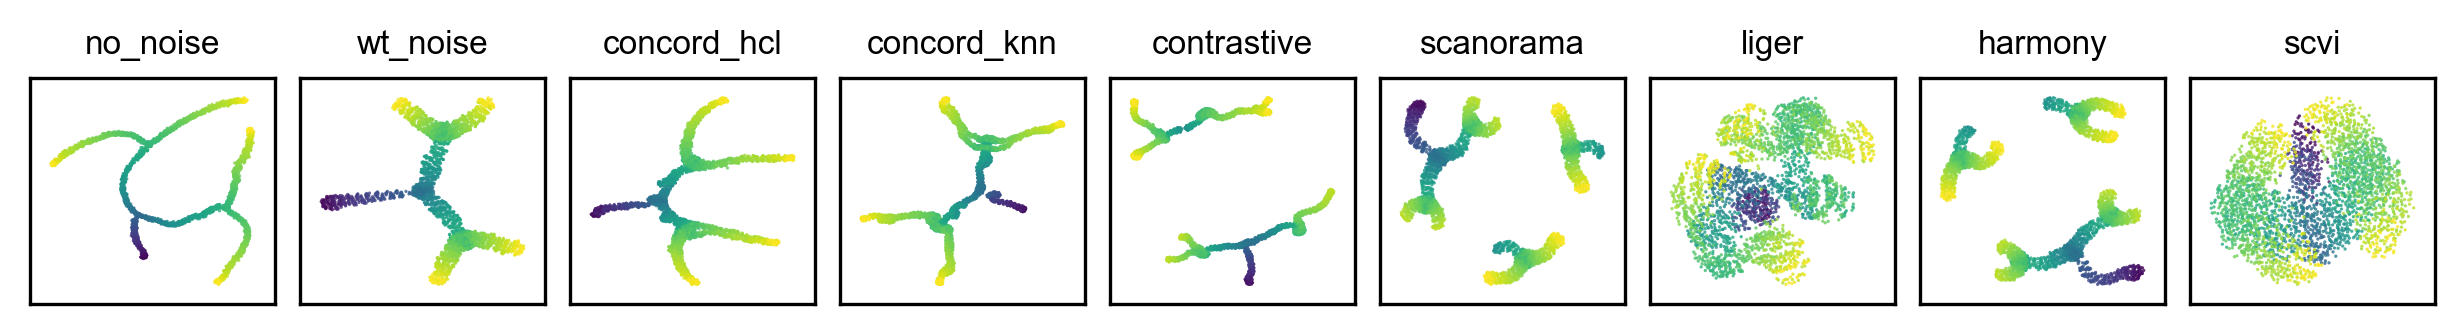

concord.plotting.pl_embedding - INFO - Plotting no_noise with batch in KNN
concord.plotting.pl_embedding - INFO - Plotting wt_noise with batch in KNN
concord.plotting.pl_embedding - INFO - Plotting concord_hcl with batch in KNN
concord.plotting.pl_embedding - INFO - Plotting concord_knn with batch in KNN
concord.plotting.pl_embedding - INFO - Plotting contrastive with batch in KNN
concord.plotting.pl_embedding - INFO - Plotting scanorama with batch in KNN
concord.plotting.pl_embedding - INFO - Plotting liger with batch in KNN
concord.plotting.pl_embedding - INFO - Plotting harmony with batch in KNN
concord.plotting.pl_embedding - INFO - Plotting scvi with batch in KNN


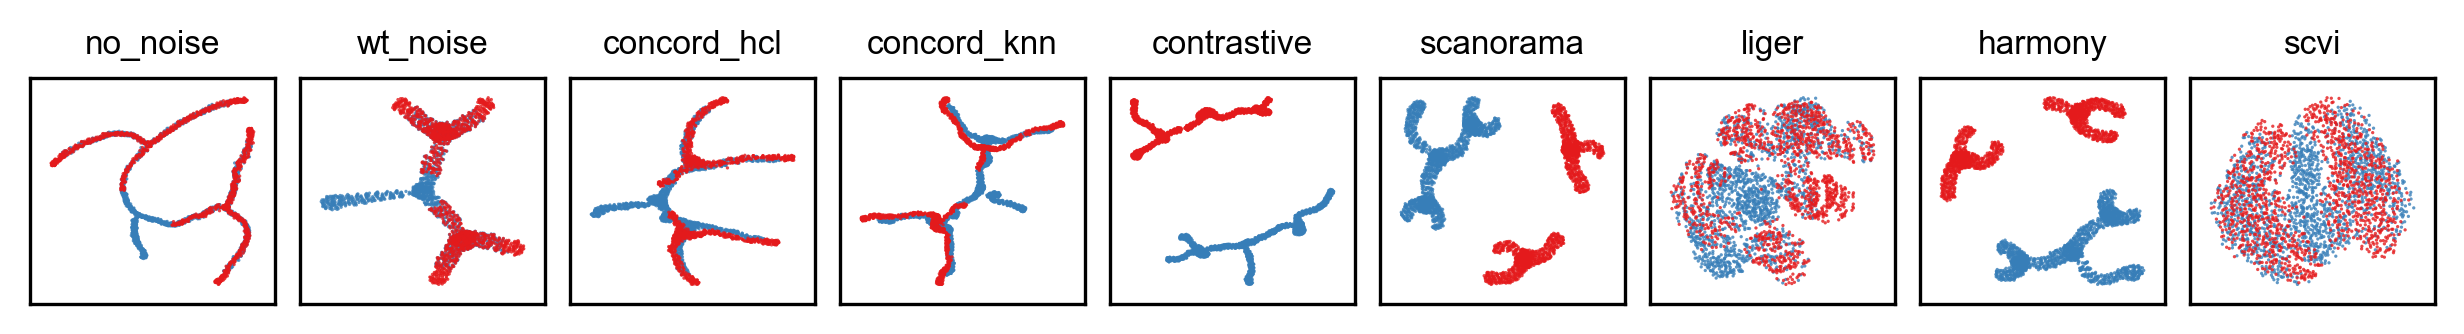

concord.plotting.pl_embedding - INFO - Plotting no_noise with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting wt_noise with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_hcl with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_knn with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting contrastive with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting scanorama with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting liger with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting harmony with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting scvi with time in UMAP


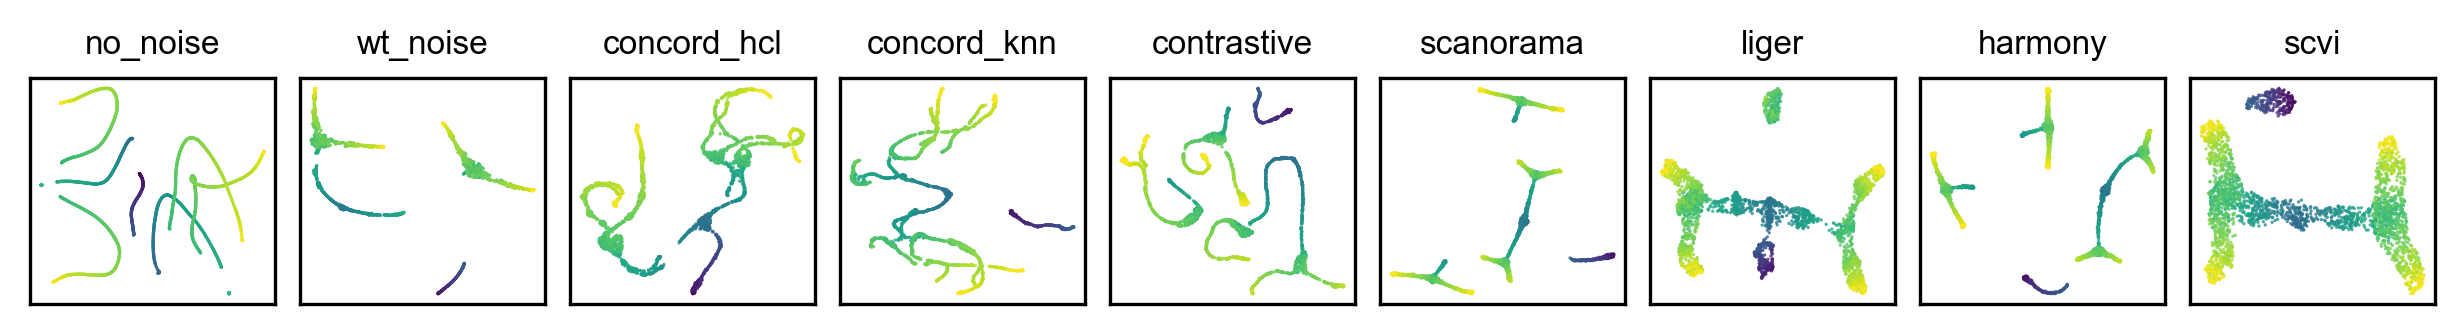

concord.plotting.pl_embedding - INFO - Plotting no_noise with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting wt_noise with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_hcl with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_knn with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting contrastive with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting scanorama with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting liger with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting harmony with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting scvi with batch in UMAP


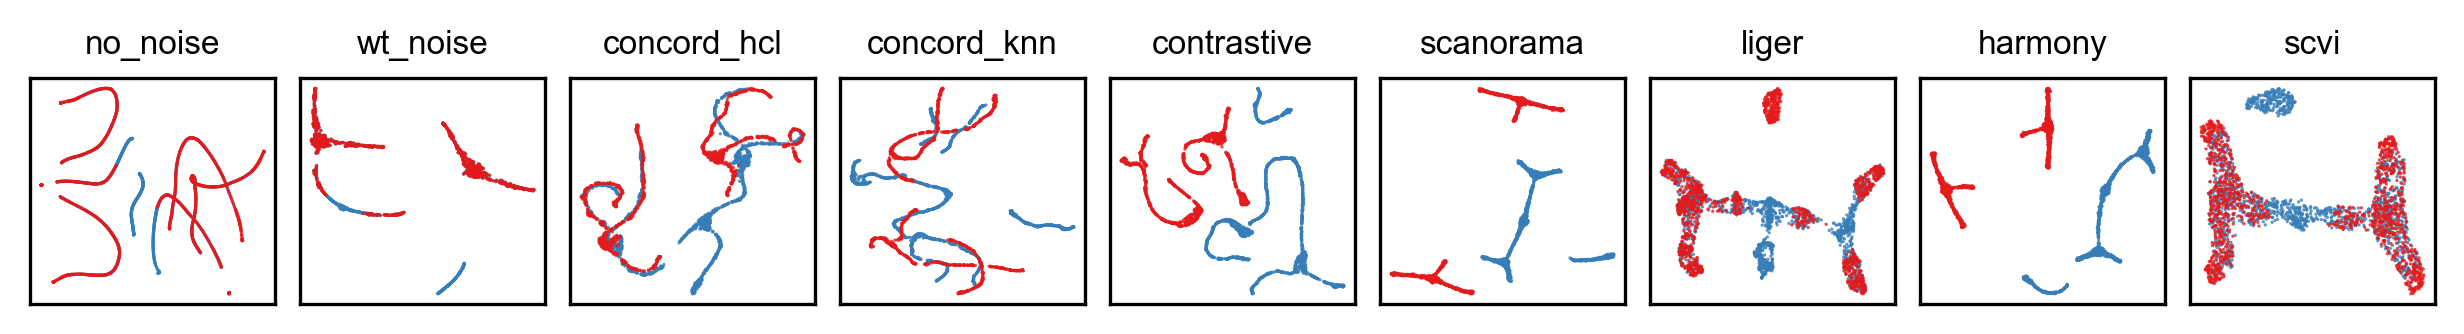

In [10]:
# plot everything
import matplotlib.pyplot as plt

show_keys = [key for key in combined_keys if key != 'unintegrated']
# check which methods are run successfully
adata.obs['time'] = adata.obs['time'].astype(float)
color_bys = ['time', 'batch']
basis_types = ['KNN', 'UMAP']
#basis_types = ['PCA']
font_size=8
point_size=2.5
alpha=0.8
figsize=(0.9*len(show_keys),1)
ncols = len(show_keys)
nrows = int(np.ceil(len(show_keys) / ncols))
pal = {'time':'viridis', 'batch':'Set1'}
k=15
k=30
edges_color='grey'
edges_width=0
layout='kk'
threshold = 0.1
node_size_scale=0.1
edge_width_scale=0.1

rasterized = True
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        show_keys,
        color_bys=color_bys,
        basis_types=basis_types,
        pal=pal,
        k=k,
        edges_color=edges_color,
        edges_width=edges_width,
        layout=layout,
        threshold=threshold,
        node_size_scale=node_size_scale,
        edge_width_scale=edge_width_scale,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        rasterized=rasterized,
        figsize=figsize,
        ncols=ncols,
        seed=seed+2,
        leiden_key='leiden',
        save_dir=save_dir,
        file_suffix=file_suffix+f'rasterized_{rasterized}',
        save_format='svg'
    )


In [39]:
# Find the indices of common genes between `adata` and `adata_state`
# sort and smooth the signal along the path
batch_id=adata.obs['batch'].unique()[0]
batch_indices = np.where(adata.obs['batch'] == batch_id)[0]
_, _, _, feature_order = ccd.ul.sort_and_smooth_signal_along_path(adata, signal_key='concord_knn', path=batch_indices, sigma=2)
adata.obsm['concord_knn_sorted'] = adata.obsm['concord_knn'][:, feature_order]
_, _, _, feature_order = ccd.ul.sort_and_smooth_signal_along_path(adata, signal_key='concord_hcl', path=batch_indices, sigma=2)
adata.obsm['concord_hcl_sorted'] = adata.obsm['concord_hcl'][:, feature_order]


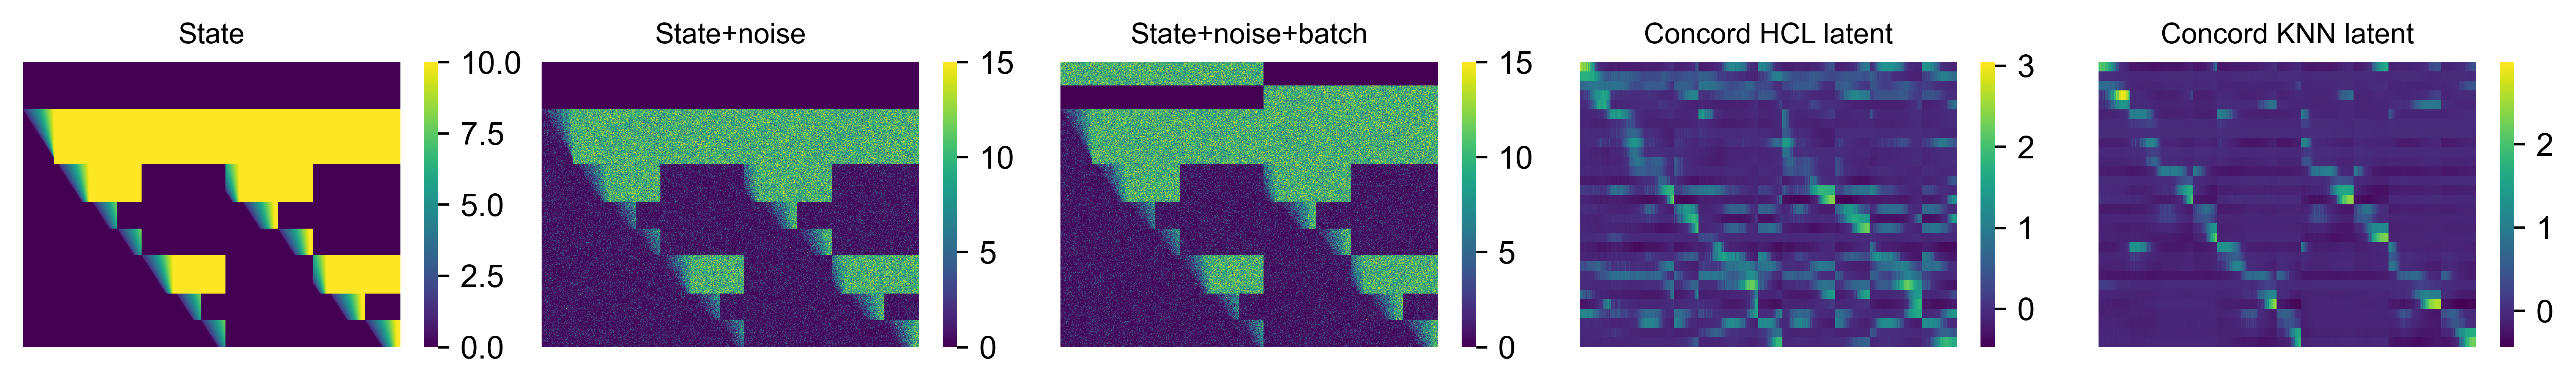

In [9]:
# Plot heatmap of original data and Concord latent
import matplotlib.pyplot as plt
figsize = (2.3, 1.8)
ncols = 5
title_fontsize = 9
_, _, state_pal = ccd.pl.get_color_mapping(adata, state_key, pal='Paired', seed=seed)
_, _, batch_pal = ccd.pl.get_color_mapping(adata, batch_key, pal='Set1', seed=seed)
pal = {state_key: state_pal, batch_key: batch_pal}
dpi = 600
with plt.rc_context(rc=custom_rc):
    fig, axes = plt.subplots(1, ncols, figsize=(figsize[0] * ncols, figsize[1]), dpi=dpi)
    ccd.pl.heatmap_with_annotations(adata, val='no_noise', obs_keys=[state_key], ax = axes[0], use_clustermap=False, pal=pal, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    ccd.pl.heatmap_with_annotations(adata, val='wt_noise', vmax=15, obs_keys=[state_key], ax = axes[1], use_clustermap=False, pal=pal, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    ccd.pl.heatmap_with_annotations(adata, val='X', vmax=15, obs_keys=[state_key, batch_key], ax = axes[2], use_clustermap=False, pal=pal, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise+batch', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    ccd.pl.heatmap_with_annotations(adata, val='concord_hcl_sorted', obs_keys=[state_key, batch_key], ax = axes[3], use_clustermap=False, pal=pal, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord HCL latent', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    ccd.pl.heatmap_with_annotations(adata, val='concord_knn_sorted', obs_keys=[state_key, batch_key], ax = axes[4], use_clustermap=False, pal=pal, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord KNN latent', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    plt.tight_layout(w_pad=0.0, h_pad=0.1)
    plt.savefig(save_dir / f"all_heatmaps_{file_suffix}.svg", dpi=dpi, bbox_inches='tight')

In [41]:
# Save result
adata.write_h5ad(data_dir / f"adata_{file_suffix}.h5ad", compression='gzip')
adata_state.write_h5ad(data_dir / f"adata_state_{file_suffix}.h5ad", compression='gzip')
print(f"Saved adata to {data_dir / f'adata_{file_suffix}.h5ad'}")
print(f"Saved adata_state to {data_dir / f'adata_state_{file_suffix}.h5ad'}")

Saved adata to ../data/simulation_tree_partial/adata_Jul25-1228.h5ad
Saved adata_state to ../data/simulation_tree_partial/adata_state_Jul25-1228.h5ad


## Evaluation

In [7]:
adata = sc.read(data_dir / f"adata_Jul25-1228.h5ad")
adata_state = sc.read(data_dir / f"adata_state_Jul25-1228.h5ad")

concord - INFO - Running SCIB benchmark


Embeddings:   0%|          | 0/10 [00:00<?, ?it/s]

INFO     root consists of a single batch or is too small. Skip.                                                    


Embeddings:  10%|█         | 1/10 [00:02<00:19,  2.20s/it]

INFO     root consists of a single batch or is too small. Skip.                                                    


Embeddings:  20%|██        | 2/10 [00:03<00:11,  1.40s/it]

INFO     root consists of a single batch or is too small. Skip.                                                    


Embeddings:  30%|███       | 3/10 [00:03<00:07,  1.11s/it]

INFO     root consists of a single batch or is too small. Skip.                                                    


Embeddings:  40%|████      | 4/10 [00:04<00:05,  1.02it/s]

INFO     root consists of a single batch or is too small. Skip.                                                    


Embeddings:  50%|█████     | 5/10 [00:05<00:04,  1.16it/s]

INFO     root consists of a single batch or is too small. Skip.                                                    


Embeddings:  60%|██████    | 6/10 [00:05<00:03,  1.24it/s]

INFO     root consists of a single batch or is too small. Skip.                                                    


Embeddings:  70%|███████   | 7/10 [00:06<00:02,  1.29it/s]

INFO     root consists of a single batch or is too small. Skip.                                                    


Embeddings:  80%|████████  | 8/10 [00:07<00:01,  1.15it/s]

INFO     root consists of a single batch or is too small. Skip.                                                    


Embeddings:  90%|█████████ | 9/10 [00:08<00:00,  1.22it/s]

INFO     root consists of a single batch or is too small. Skip.                                                    


Embeddings: 100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


concord - INFO - Running Probe benchmark
concord - INFO - Running linear probe for state with keys ['no_noise', 'wt_noise', 'concord_hcl', 'concord_knn', 'contrastive', 'unintegrated', 'scanorama', 'liger', 'harmony', 'scvi']
Detected task: classification
concord - INFO - Running k-NN probe for state with keys ['no_noise', 'wt_noise', 'concord_hcl', 'concord_knn', 'contrastive', 'unintegrated', 'scanorama', 'liger', 'harmony', 'scvi']
[KNN] detected task: classification
concord - INFO - Running Topology benchmark
concord - INFO - Computing persistent homology for no_noise
concord - INFO - Computing persistent homology for 1000 points in 30 dimensions...
concord - INFO - Computing persistent homology for wt_noise
concord - INFO - Computing persistent homology for 1000 points in 30 dimensions...
concord - INFO - Computing persistent homology for concord_hcl
concord - INFO - Computing persistent homology for 1000 points in 30 dimensions...
concord - INFO - Computing persistent homology fo

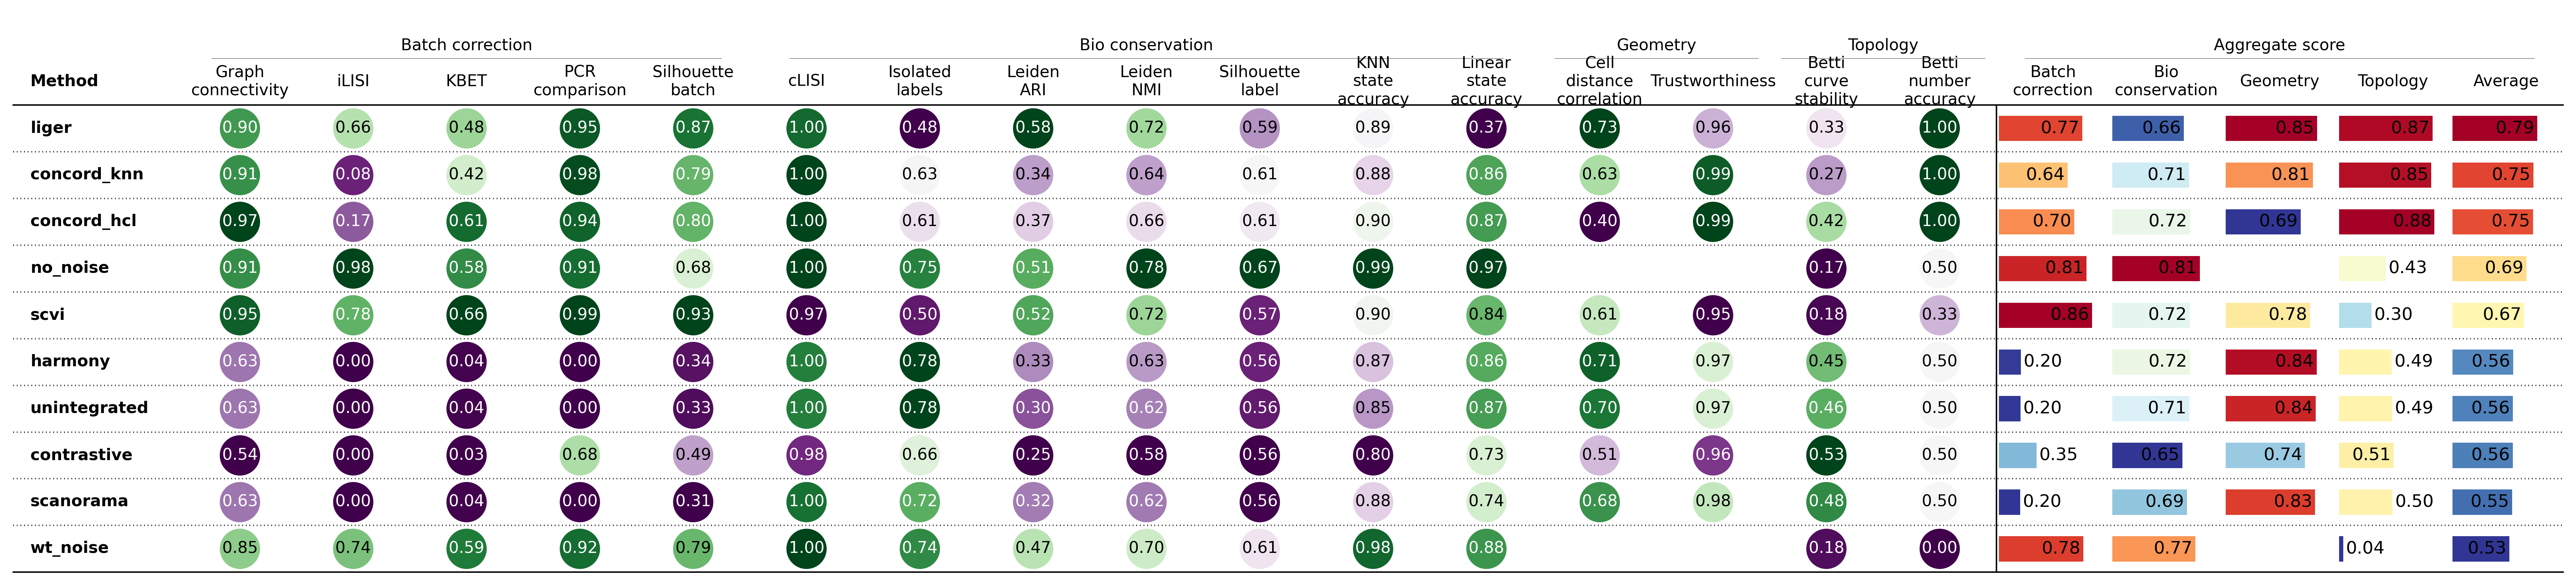

concord - INFO - Saved benchmark results to ../save/dev_simulation_tree_partial-Jul25/benchmarks_out/benchmark_results_Jul25-1228.pkl


Batch correction                                     \
            Graph connectivity     iLISI      KBET PCR comparison   
liger                 0.897345  0.658487  0.481794       0.952012   
concord_knn           0.905636  0.077368  0.419895       0.978131   
concord_hcl           0.967877  0.165007  0.614065       0.935353   
no_noise              0.907014  0.980991  0.575451       0.914575   
scvi                  0.945636  0.777731  0.661307       0.994094   

                             Bio conservation                             \
            Silhouette batch            cLISI Isolated labels Leiden ARI   
liger               0.871354         0.998153        0.482414   0.576544   
concord_knn         0.794471              1.0        0.631052   0.341962   
concord_hcl         0.796816              1.0        0.611874   0.374805   
no_noise            0.678462              1.0        0.747498   0.512185   
scvi                0.928068         0.974227        0.500589   0.515779   

                                         ...                        \
            Leiden NMI Silhouette label  ... Linear state accuracy   
liger         0.719761          0.58622  ...              0.366667   
concord_knn   0.636032         0.612711  ...              0.864815   
concord_hcl   0.662497         0.608139  ...              0.872222   
no_noise      0.780229         0.670129  ...              0.974074   
scvi          0.722078         0.565031  ...              0.838889   

                             Geometry                              Topology  \
            Cell distance correlation Trustworthiness Betti curve stability   
liger                        0.730111        0.964436              0.332616   
concord_knn                  0.627215        0.987567              0.273708   
concord_hcl                  0.399956        0.989332              0.419992   
no_noise                          NaN             NaN              0.173056   
scvi                         0.611005        0.952338              0.179338   

                                   Aggregate score                             \
            Betti number accuracy Batch correction Bio conservation  Geometry   
liger                    1.000000         0.772198         0.660601  0.847274   
concord_knn              1.000000         0.635100         0.709193  0.807391   
concord_hcl              1.000000         0.695824         0.718770  0.694644   
no_noise                 0.500000         0.811299         0.810694       NaN   
scvi                     0.333333         0.861367         0.716656  0.781671   

                                 
             Topology   Average  
liger        0.866523  0.786649  
concord_knn  0.854742  0.751606  
concord_hcl  0.883998  0.748309  
no_noise     0.434611  0.685534  
scvi         0.302534  0.665557  

[5 rows x 21 columns]

In [42]:
out = ccd.bm.run_benchmark_pipeline(
    adata,
    embedding_keys=combined_keys,
    state_key=state_key,
    batch_key=batch_key,
    groundtruth_key="no_noise",  # use the Leiden clusters as ground truth
    save_dir=save_dir / "benchmarks_out",
    file_suffix=file_suffix,  # e.g. "2025-06-25"
    run=("scib", "probe", "geometry", "topology"),          # run only these blocks
    plot_individual=False,          # skip the intermediate PDFs
    expected_betti_numbers=[0,0,0],  # expected Betti numbers for the geometry and topology blocks
    max_points=1000,
    verbose=True,
    seed=seed,  # for reproducibility
)
combined = out["combined"]
combined.head()

In [44]:
import pickle
out = pickle.load(open(Path("../save/dev_simulation_tree_partial-Jul25/benchmarks_out") / f"benchmark_results_Jul25-1228.pkl", "rb"))
combined = out["combined"]

with open('../save/dev_simulation_tree_partial-Jul25/benchmarks_out/topology_diagrams_Jul25-1228.pkl', 'rb') as f:
    diagrams = pickle.load(f)

geometry_full = pickle.load(open(Path("../save/dev_simulation_tree_partial-Jul25/benchmarks_out/geometry_results_Jul25-1228.pkl"), "rb"))


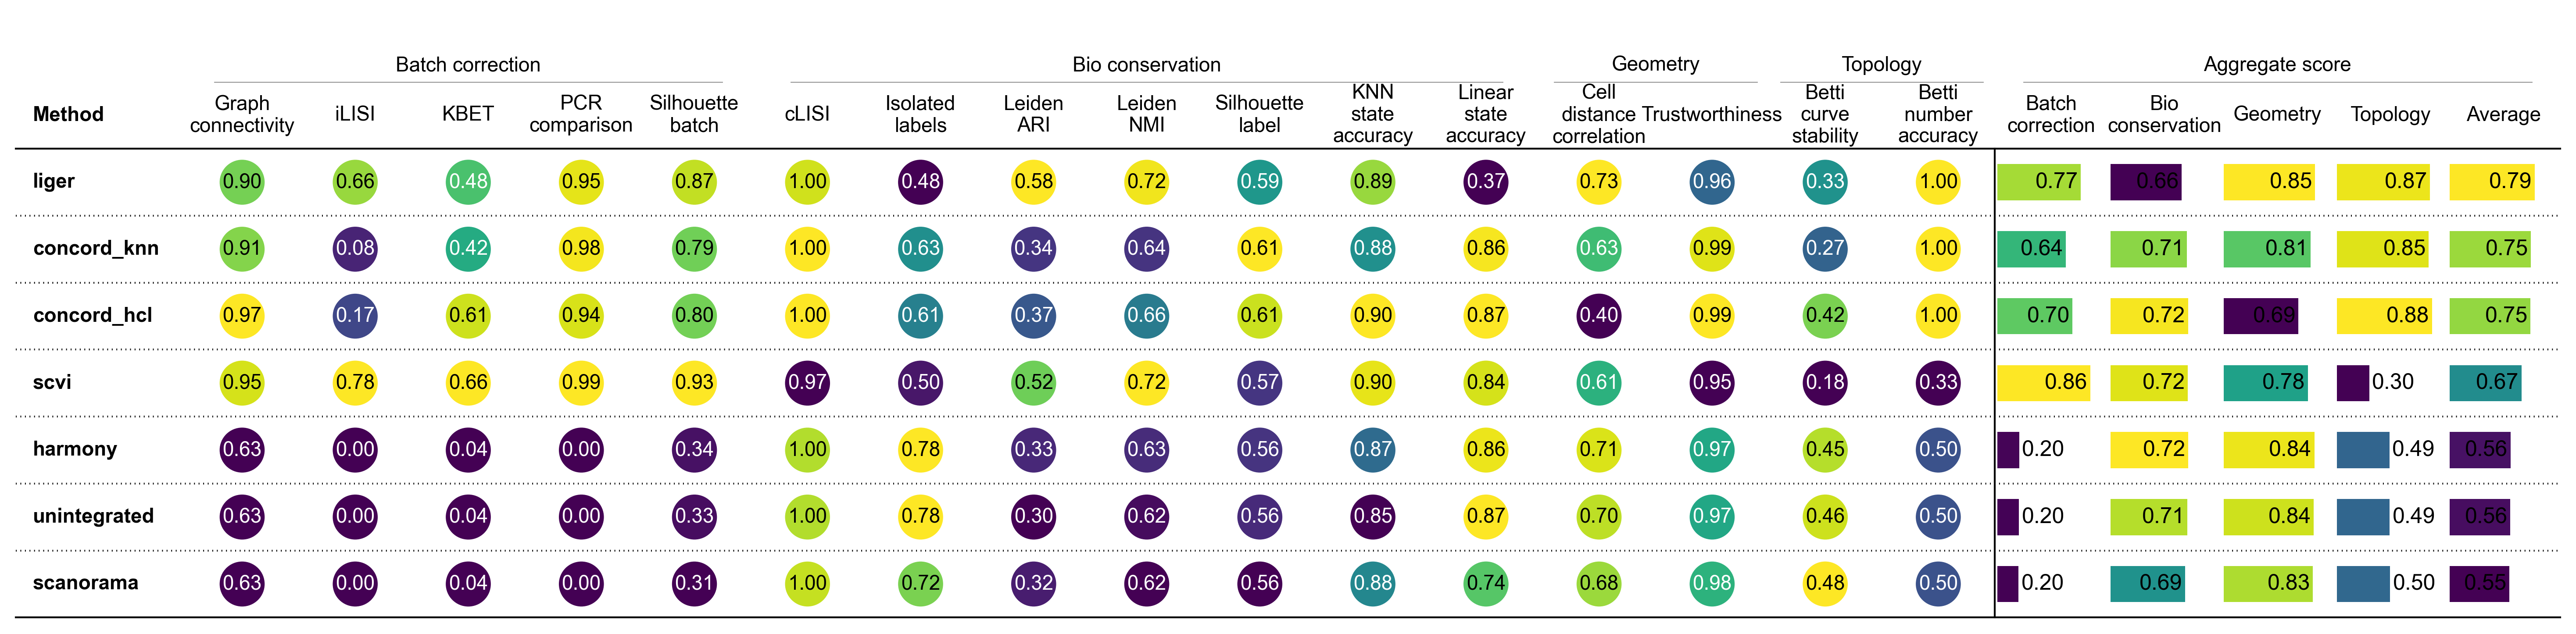

In [45]:
import pickle
table_plot_kw = dict(
        pal="viridis", pal_agg="viridis", cmap_method="minmax", dpi=300)
with plt.rc_context(rc=custom_rc):
    combined_df = ccd.bm.combine_benchmark_results(
        out,
        block_include=("geometry", "topology", "scib", "probe"),
        plot=False,
        save_path=save_dir / f"combined_res_{file_suffix}.pdf",
        table_plot_kw=table_plot_kw,
    )
    # drop method "contrastive"
    combined_df = combined_df[combined_df.index != "contrastive"]
    ccd.bm.plot_benchmark_table(
            combined_df.dropna(axis=0, how='any'),
            save_path=save_dir / f"benchmark_table_{file_suffix}.svg",
            agg_name="Aggregate score",
            figsize=(25, 6),
            **table_plot_kw
            )

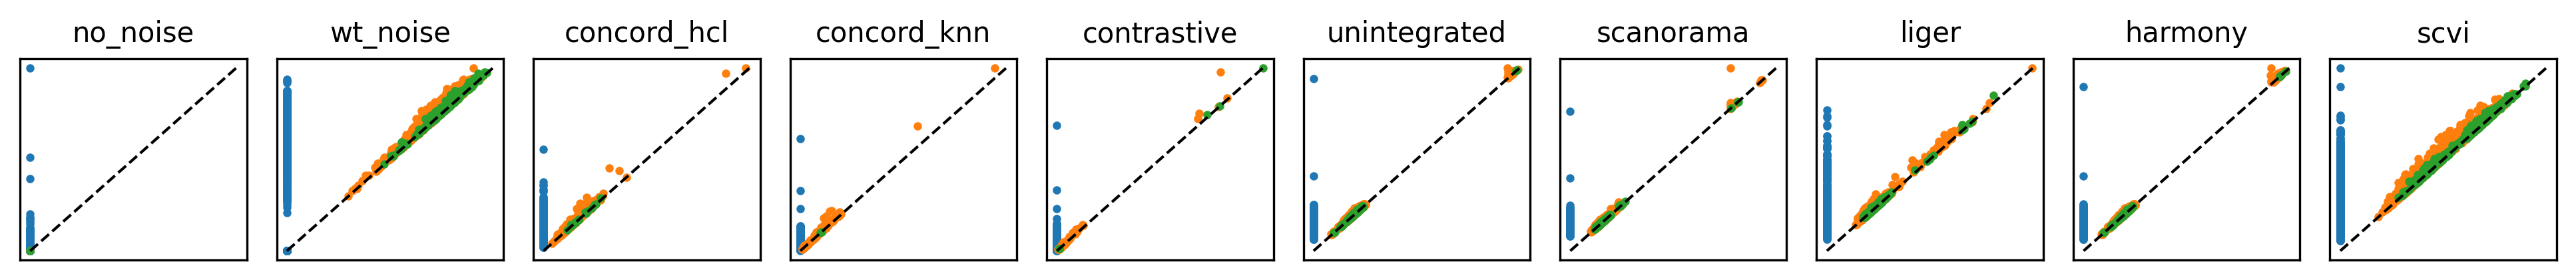

In [46]:
# Reorder diagrams with the same order as the combined keys
diagrams_ordered = {key: diagrams[key] for key in combined_keys}
ccd.pl.plot_persistence_diagrams(diagrams_ordered, base_size=(1.3, 1.5), dpi=300, marker_size=4, n_cols=len(diagrams_ordered), fontsize=10, save_path=save_dir / f"persistence_diagrams_{file_suffix}.pdf", legend=False, label_axes=False, axis_ticks=False)

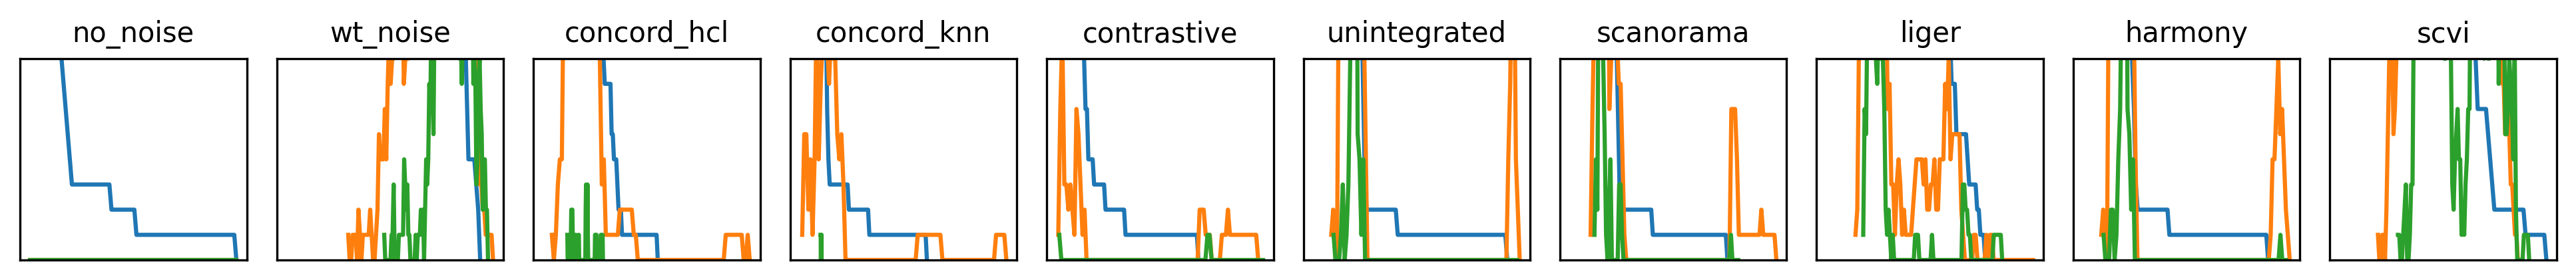

In [47]:
ccd.pl.plot_betti_curves(diagrams_ordered, nbins=100, base_size=(1.3, 1.5), n_cols=len(diagrams_ordered), fontsize=10, save_path=save_dir / f"betti_curves_{file_suffix}.pdf", dpi=300, legend=False, label_axes=False, axis_ticks=False)

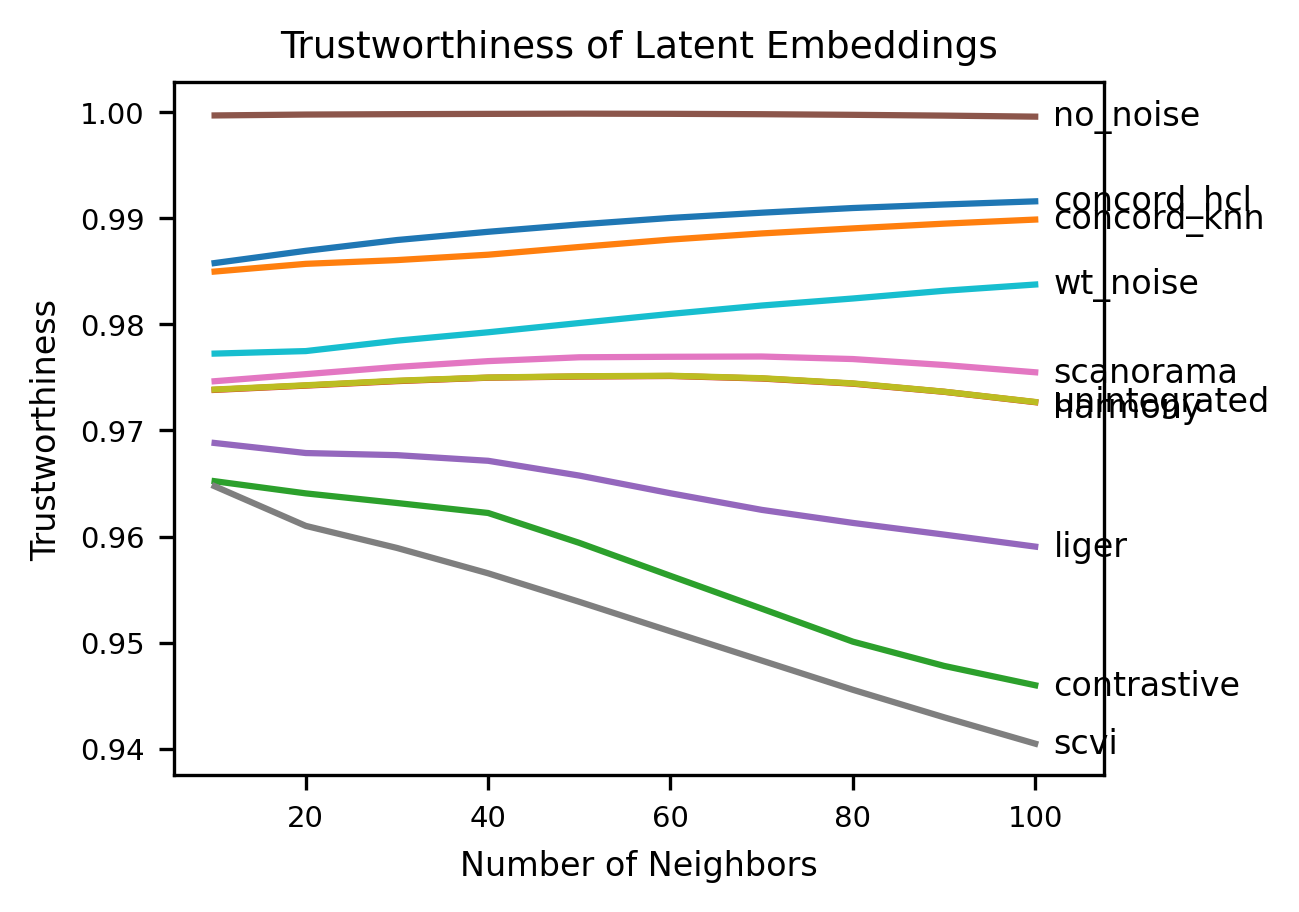

In [48]:
trustworthiness_scores = geometry_full['trustworthiness']['scores']
ccd.pl.plot_trustworthiness(trustworthiness_scores, text_shift=2, min_gap=0.0005, legend=False, save_path=save_dir / f"trustworthiness_{file_suffix}.pdf", figsize=(4,3))
